In [1]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = [8, 3]
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels

import scipy
from scipy.stats import pearsonr

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
print(matplotlib.__version__)
print(pd.__version__)
print(np.__version__)
print(statsmodels.__version__)
print(scipy.__version__)


3.3.1
1.1.0
1.19.1
0.11.1
1.5.2


## Obtain and visualize data

In [3]:
## data obtained from https://datahub.io/core/global-temp#data
df = pd.read_csv("global_temps.csv")
df.head()

,Source,Date,Mean
0,GCAG,2016-12-06,0.7895
1,GISTEMP,2016-12-06,0.8100
2,GCAG,2016-11-06,0.7504
3,GISTEMP,2016-11-06,0.9300
4,GCAG,2016-10-06,0.7292


In [4]:
df.shape

(3288, 3)

<AxesSubplot:>

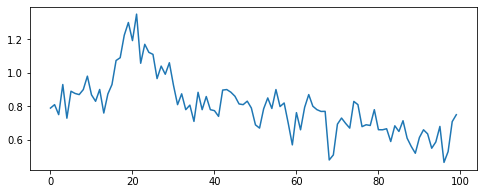

In [5]:
df.Mean[:100].plot()

<AxesSubplot:>

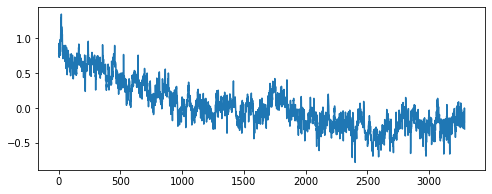

In [6]:
df.Mean.plot()

She is plotting the first 100 points.  She recommends it is sometime good NOT to plot the whole series because

## Exercise: what is wrong with the data and plot above? How can we fix this?

Answer: You are combining sources.  These are actually two separate time series. A hint to the error is that x-axis is not showing time for the time series.

So let's fix it: 

In [7]:
 df = df.pivot(index = 'Date', columns='Source', values='Mean')

In [8]:
df.index

Index(['1880-01-06', '1880-02-06', '1880-03-06', '1880-04-06', '1880-05-06',
       '1880-06-06', '1880-07-06', '1880-08-06', '1880-09-06', '1880-10-06',
       ...
       '2016-03-06', '2016-04-06', '2016-05-06', '2016-06-06', '2016-07-06',
       '2016-08-06', '2016-09-06', '2016-10-06', '2016-11-06', '2016-12-06'],
      dtype='object', name='Date', length=1644)

In [9]:
df.columns.to_list()

['GCAG', 'GISTEMP']

In [10]:
df.head()

Source,GCAG,GISTEMP
Date,,
1880-01-06,0.0009,-0.30
1880-02-06,-0.1229,-0.21
1880-03-06,-0.1357,-0.18
1880-04-06,-0.0499,-0.27
1880-05-06,-0.0738,-0.14


<AxesSubplot:xlabel='Date'>

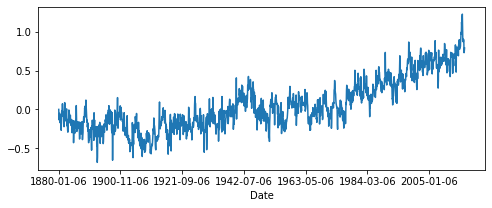

In [11]:
df.GCAG.plot()

In [ ]:
type(df.index)

## Exercise: how can we make the index more time aware?

**Really Important Trick!**

It makes it really easy to filter and select data based on date and date ranges.

In [12]:
df.index = pd.to_datetime(df.index)

In [13]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

<AxesSubplot:xlabel='Date'>

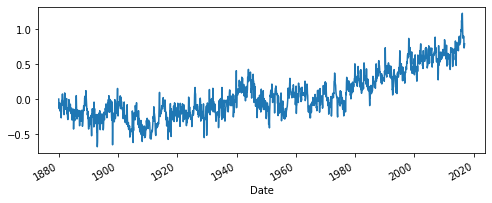

In [14]:
df.GCAG.plot()

In [15]:
df['1880']

Source,GCAG,GISTEMP
Date,,
1880-01-06,0.0009,-0.30
1880-02-06,-0.1229,-0.21
1880-03-06,-0.1357,-0.18
1880-04-06,-0.0499,-0.27
1880-05-06,-0.0738,-0.14
1880-06-06,-0.1692,-0.29
1880-07-06,-0.1491,-0.24
1880-08-06,-0.0725,-0.08
1880-09-06,-0.0817,-0.17


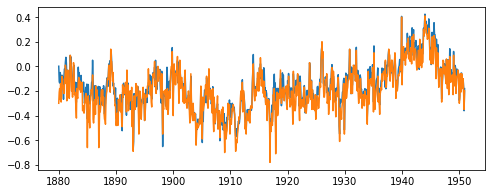

In [16]:
plt.plot(df['1880':'1950'][['GCAG', 'GISTEMP']])

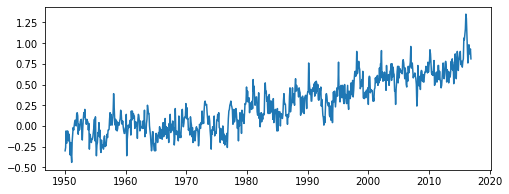

In [17]:
plt.plot(df['1950':][['GISTEMP']])

## Exercise: How strongly do these measurements correlate contemporaneously? What about with a time lag?

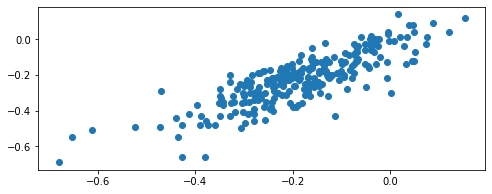

In [18]:
plt.scatter(df['1880':'1900'][['GCAG']], df['1880':'1900'][['GISTEMP']])

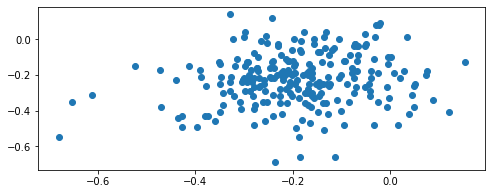

In [19]:
plt.scatter(df['1880':'1899'][['GCAG']], df['1881':'1900'][['GISTEMP']])

In [20]:
pearsonr(df['1880':'1899'].GCAG, df['1881':'1900'].GISTEMP)

(0.1546405732961276, 0.01650223473095511)

In [21]:
df['1880':'1899'][['GCAG']].head()

Source,GCAG
Date,
1880-01-06,0.0009
1880-02-06,-0.1229
1880-03-06,-0.1357
1880-04-06,-0.0499
1880-05-06,-0.0738


In [22]:
df['1881':'1900'][['GISTEMP']].head()

Source,GISTEMP
Date,
1881-01-06,-0.10
1881-02-06,-0.14
1881-03-06,0.01
1881-04-06,-0.03
1881-05-06,-0.04


In [23]:
min(df.index)

Timestamp('1880-01-06 00:00:00')

In [24]:
max(df.index)

Timestamp('2016-12-06 00:00:00')

## Unobserved component model

In [ ]:
train = df['1960':]

### model parameters

In [ ]:
# smooth trend model without seasonal or cyclical components
model = {
    'level': 'smooth trend', 'cycle': False, 'seasonal': None, 
}


### fitting a model

In [ ]:
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html
gcag_mod = sm.tsa.UnobservedComponents(train['GCAG'], **model)
gcag_res = gcag_mod.fit()

In [ ]:
fig = gcag_res.plot_components(legend_loc='lower right', figsize=(15, 9));

## Plotting predictions

In [ ]:
# Perform rolling prediction and multistep forecast
num_steps = 20
predict_res = gcag_res.get_prediction(dynamic=train['GCAG'].shape[0] - num_steps)

predict = predict_res.predicted_mean
ci = predict_res.conf_int()

In [ ]:
plt.plot(predict)

In [ ]:
plt.scatter(train['GCAG'], predict)

In [ ]:
fig, ax = plt.subplots()
# Plot the results
ax.plot(train['GCAG'], 'k.', label='Observations');
ax.plot(train.index[:-num_steps], predict[:-num_steps], label='One-step-ahead Prediction');

ax.plot(train.index[-num_steps:], predict[-num_steps:], 'r', label='Multistep Prediction');
ax.plot(train.index[-num_steps:], ci.iloc[-num_steps:], 'k--');

# Cleanup the image
legend = ax.legend(loc='upper left');

In [ ]:
fig, ax = plt.subplots()
# Plot the results
ax.plot(train.index[-40:], train['GCAG'][-40:], 'k.', label='Observations');
ax.plot(train.index[-40:-num_steps], predict[-40:-num_steps], label='One-step-ahead Prediction');

ax.plot(train.index[-num_steps:], predict[-num_steps:], 'r', label='Multistep Prediction');
ax.plot(train.index[-num_steps:], ci.iloc[-num_steps:], 'k--');

# Cleanup the image
legend = ax.legend(loc='upper left');

## Exercise: consider adding a seasonal term for 12 periods for the model fit above. Does this improve the fit of the model?

In [ ]:
seasonal_model = {
    'level': 'local linear trend',
    'seasonal': 12
}
mod = sm.tsa.UnobservedComponents(train['GCAG'], **seasonal_model)
res = mod.fit(method='powell', disp=False)

In [ ]:
fig = res.plot_components(legend_loc='lower right', figsize=(15, 9));

## How does this compare to the original model?

In [ ]:
pearsonr(gcag_res.predict(), train['GCAG'])

In [ ]:
np.mean(np.abs(gcag_res.predict() - train['GCAG']))

In [ ]:
np.mean(np.abs(res.predict() - train['GCAG']))

## Explore the seasonality more

In [ ]:
seasonal_model = {
    'level': 'local level',
    'seasonal': 12
}
llmod = sm.tsa.UnobservedComponents(train['GCAG'], **seasonal_model)
ll_level_res = llmod.fit(method='powell', disp=False)

In [ ]:
fig = ll_level_res.plot_components(legend_loc='lower right', figsize=(15, 9));

In [ ]:
np.mean(np.abs(ll_level_res.predict() - train['GCAG']))

In [ ]:
train[:48].GCAG.plot()

## Exercise: a common null model for time series is to predict the value at time t-1 for the value at time t. How does such a model compare to the models we fit here?

### Consider correlation

In [ ]:
pearsonr(ll_level_res.predict(), train['GCAG'])

In [ ]:
pearsonr(train['GCAG'].iloc[:-1, ], train['GCAG'].iloc[1:, ])

### What about mean absolute error?

In [ ]:
np.mean(np.abs(ll_level_res.predict() - train['GCAG']))

In [ ]:
np.mean(np.abs(train['GCAG'].iloc[:-1, ].values, train['GCAG'].iloc[1:, ].values))